<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/MINE_0219.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MINE

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
data_size = 20000
cor = [0.5, 1, 1.5, 2.5, 3]

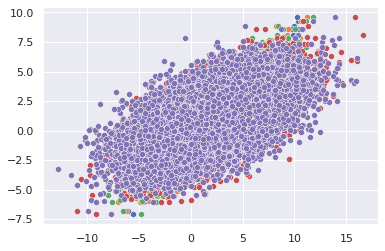

In [4]:
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,6))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

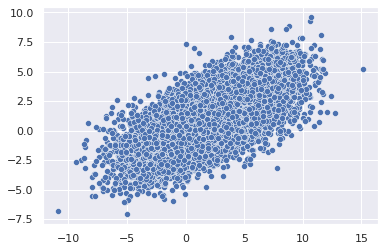

In [5]:
for i in range(200):
    os = i*100
    x[os:os+100,4] = y[os:os+100] + np.random.normal(1,1+(i/100),100)
    x[os:os+100,5] = i
sns.scatterplot(x=x[:,4],y=y)

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [17]:
mi_scores = make_mi_scores(pd.DataFrame(x,columns=['x0','x1','x2','x3','x4','ix']), y, discrete_features="auto")
print(mi_scores)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


x0    1.427396
x1    0.808041
x2    0.508595
x4    0.347852
x3    0.259270
ix    0.000437
Name: MI Scores, dtype: float64


In [8]:
for i in range(200):
    os = i*100
    mi_scores = make_mi_scores(pd.DataFrame(x[os:os+100,4],columns=['x4']), y[os:os+100], discrete_features="auto")
    print(i, mi_scores)

0 x4    0.85871
Name: MI Scores, dtype: float64
1 x4    0.829091
Name: MI Scores, dtype: float64
2 x4    0.956678
Name: MI Scores, dtype: float64
3 x4    0.597578
Name: MI Scores, dtype: float64
4 x4    0.738346
Name: MI Scores, dtype: float64
5 x4    0.739858
Name: MI Scores, dtype: float64
6 x4    0.583621
Name: MI Scores, dtype: float64
7 x4    0.600263
Name: MI Scores, dtype: float64
8 x4    0.731003
Name: MI Scores, dtype: float64
9 x4    0.753232
Name: MI Scores, dtype: float64
10 x4    0.652573
Name: MI Scores, dtype: float64
11 x4    0.970828
Name: MI Scores, dtype: float64
12 x4    0.827068
Name: MI Scores, dtype: float64
13 x4    0.475537
Name: MI Scores, dtype: float64
14 x4    0.800913
Name: MI Scores, dtype: float64
15 x4    0.83561
Name: MI Scores, dtype: float64
16 x4    0.488729
Name: MI Scores, dtype: float64
17 x4    0.873268
Name: MI Scores, dtype: float64
18 x4    0.7457
Name: MI Scores, dtype: float64
19 x4    0.589723
Name: MI Scores, dtype: float64
20 x4    0.663

(20000, 6)
(20000, 1)


100%|██████████| 300/300 [00:10<00:00, 28.95it/s]


tensor([ 1.4127e+00,  7.9214e-01,  5.1487e-01,  2.7013e-01,  3.6302e-01,
        -1.6761e-04], grad_fn=<CopySlices>)


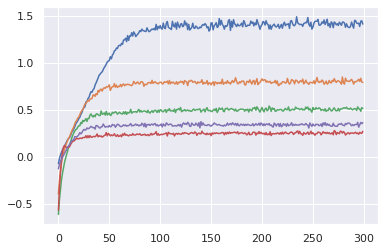

In [9]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 10000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = [Net() for i in range(x.shape[1])]
optimizer = [torch.optim.Adam(model[i].parameters(), lr=0.01) for i in range(x.shape[1])]

plot_loss = []

y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    back_loss = torch.zeros(6)
    s = np.random.choice(x.shape[0],minibatch)
    for i in range(x.shape[1]):
        x_sample = Variable(torch.from_numpy(x[s,i].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(model[i](x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model[i](x_sample, y_shuffle))))
        loss = - ret  # maximize
        model[i].zero_grad()
        loss.backward()
        optimizer[i].step()
        back_loss[i] = ret

    plot_loss.append(back_loss.data.numpy())


    #back_loss = loss

print('')
print(back_loss)

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[:,0])
plt.plot(plot_loss[:,1])
plt.plot(plot_loss[:,2])
plt.plot(plot_loss[:,3])
plt.plot(plot_loss[:,4])

(20000, 6)
(20000, 1)


100%|██████████| 40/40 [00:06<00:00,  5.79it/s]


tensor([-1.6205e-03,  4.2939e-04, -1.4967e-05, -1.5055e-04, -5.6182e-05,
         0.0000e+00])
x0    1.427396
x1    0.808041
x2    0.508595
x4    0.347852
x3    0.259270
ix    0.000437
Name: MI Scores, dtype: float64
[1.3879373  0.790126   0.50050217 0.2505709  0.33800977]


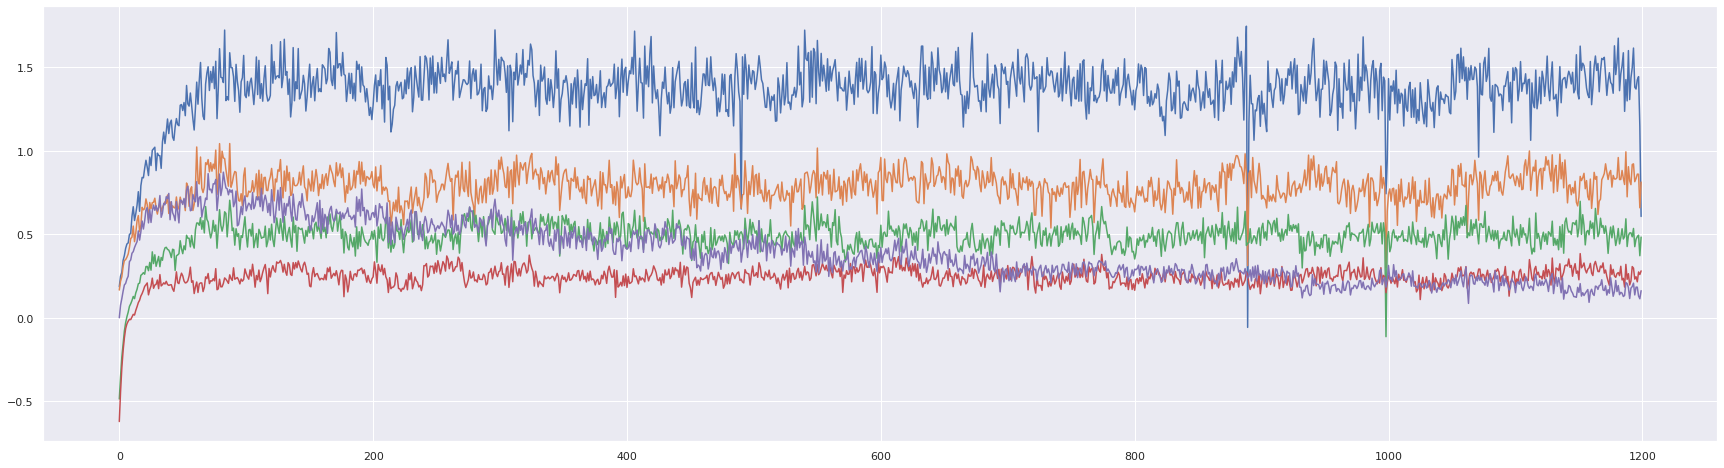

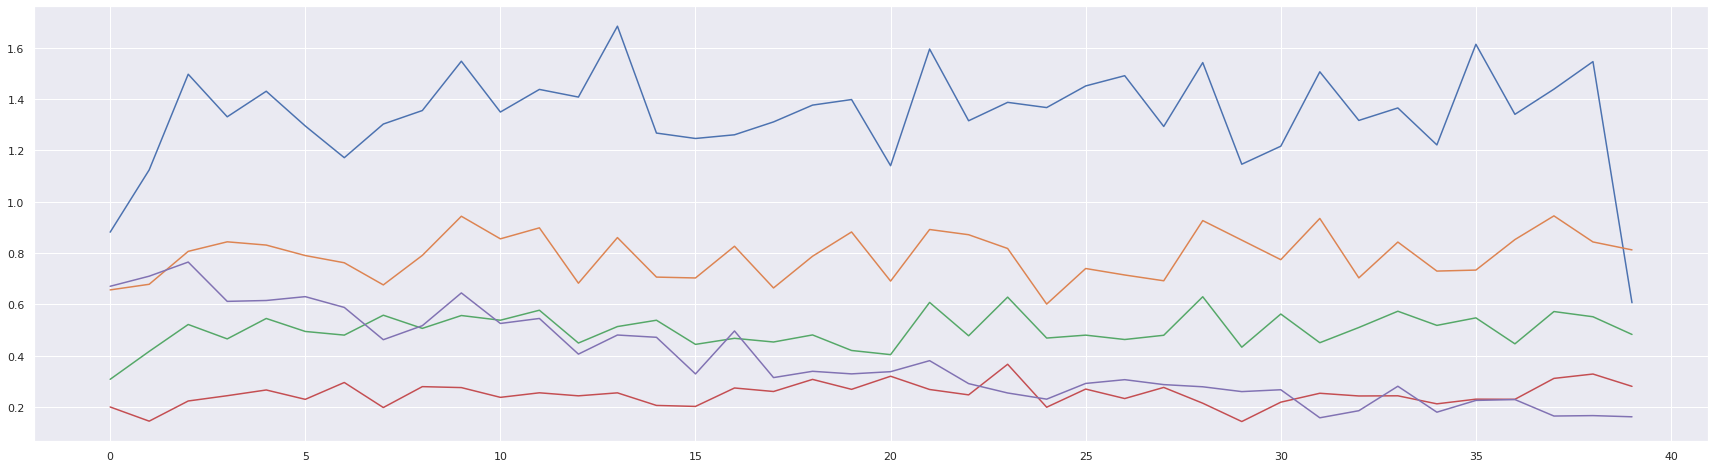

In [82]:
from tqdm import tqdm

H=20
n_epoch = 1200
minibatch = 10000

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()
        
        for i in range(self.input_dim-1): 
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))
            #self.fc4.append(nn.Linear(2, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim-1):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y))
            h1 = self.fc3[i](h0)
            #h2 = self.fc3[i](torch.cat((h0, x[:,-1].reshape(-1,1)), 1) )
            h.append(h1)

        return torch.cat(h, dim=1)  

model = Net(x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []
chunk_loss = []
di = []
y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for chunk in tqdm(range(40)):
    for epoch in range(30):
        #i = epoch%100
        s = [*range(chunk*500,chunk*500+500)]  
        #s = np.random.choice(x.shape[0],minibatch)
        x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        p_xy = model(x_sample, y_sample)
        p_x_y = model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret  # maximize

        model.zero_grad()
        #loss.retain_grad()
        loss.mean().backward()
        optimizer.step()

        plot_loss.append(-loss.data.numpy())

        #dx = torch.autograd.grad(ret, x_sample[-1,5])
        #print(dx)

        #di.append(loss.grad)

        #back_loss = loss
        #if i == 99:
        #    print(loss[4])
    #chunk_loss.append(-loss.data.numpy())

print(x_sample.grad[-1,:])

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=['x0','x1','x2','x3','x4','ix'])
df_loss.rolling(window=5).mean().plot()

di = np.asarray(di)
print(mi_scores)
print(np.mean(plot_loss[200:,:],0))
#print(np.mean(di[200:,0],0))

#print(x_sample.grad)
plt.figure(figsize=(30,8))
plt.plot(plot_loss[:,0:5])
plt.show()

chunk_loss = np.asarray(chunk_loss)
plt.figure(figsize=(30,8))
plt.plot(chunk_loss[:,0:5])
plt.show()


-1.5717192490895536e-05
7.201268275578876e-06
1.3201246658961497e-06
9.83306765556334e-06
-0.00046287403901418045


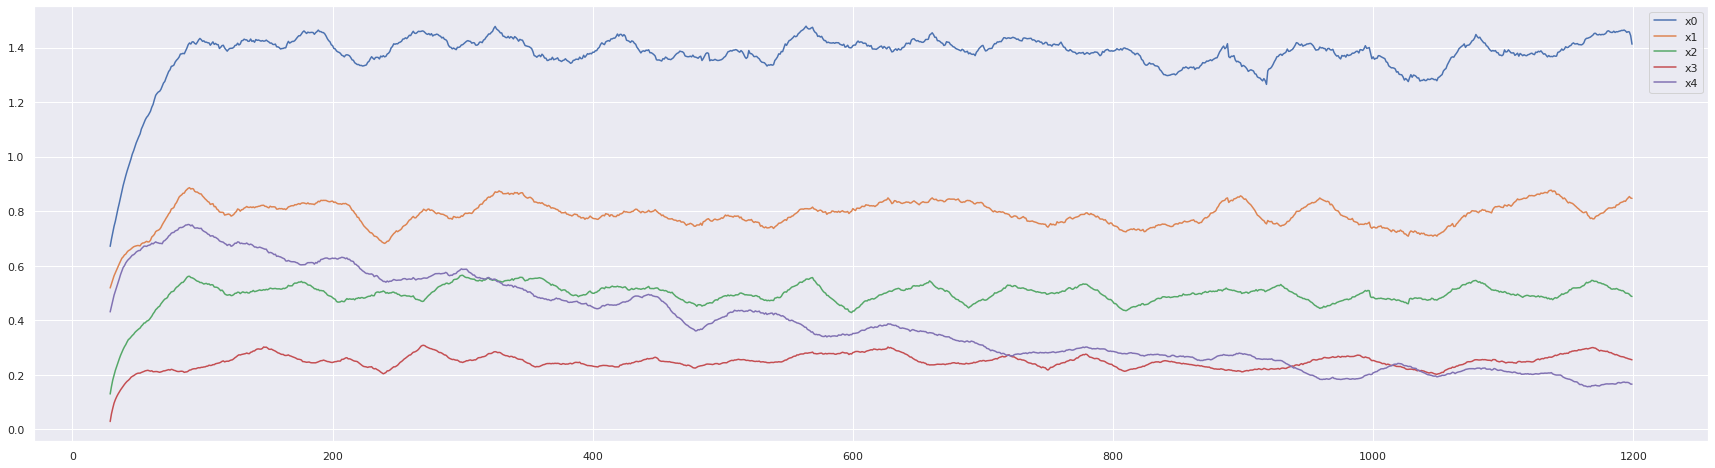

In [92]:
plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=['x0','x1','x2','x3','x4'])
df_sloss = df_loss.rolling(window=30).mean()
df_sloss.plot(figsize=(30,8))

print(np.mean(np.gradient(df_sloss[200:]['x0'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x1'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x2'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x3'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x4'].values)))

In [88]:
df_sloss

,x0,x1,x2,x3,x4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1195,1.455840,0.843542,0.499519,0.261453,0.172525
1196,1.458240,0.848938,0.498765,0.259426,0.172204
1197,1.457176,0.853911,0.495374,0.258238,0.170028
1198,1.443647,0.848316,0.489699,0.256872,0.166236


In [72]:
print(np.mean(di[200:,:],0))
plt.figure(figsize=(30,8))
plt.plot(di[:,4])
plt.show()

IndexError: ignored

In [79]:
di

array([None, None, None, ..., None, None, None], dtype=object)

+ 편미분 Test

In [ ]:
def uc(a,b):
    return a*b[0] + b[1]

In [ ]:
x = torch.tensor(100.0, requires_grad=True)
t = torch.tensor(2.0, requires_grad=True)
print(x)
print(t)
u = x**2 * t
print(u)
# 1st derivatives
#dt = torch.autograd.grad(u, t)[0]
#print(dt)
dx = torch.autograd.grad(u, x,create_graph=True)[0]
print(dx)
# 2nd derivatives (higher orders require `create_graph=True`)
ddx = torch.autograd.grad(dx, x)[0]
print(ddx)

In [ ]:
tx = torch.tensor([*range(200)],dtype=float, requires_grad=True)
ty = tx * torch.normal(1.0,0.5,size=(200,))
dx = torch.autograd.grad(torch.sum(ty), tx)[0]
print(np.mean(dx.tolist()))

In [ ]:
plt.plot(ty.detach().numpy(),'.')

In [ ]:
a = torch.rand(10, requires_grad=True)
b = torch.rand(10, requires_grad=True)

output = (2 * a).sum()

c = torch.autograd.grad(output, (a, b),allow_unused=True)
c

In [ ]:
aa = np.random.rand(3,3)
aa

In [ ]:
aa[:,[1,-1]]